# Importing Libraries

In [1]:
import os
import cv2
from sklearn.utils import shuffle 
import seaborn as sn; sn.set(font_scale=1.2)
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

# Loading Dataset

In [2]:
class_names = ['Benign cases','Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
def load_data():
  
    datasets = ['train', 'test']
    output = []    
    for dataset in datasets:        
        images = []
        labels = []        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):                
                img_path = os.path.join(os.path.join(dataset, folder), file)                
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE)                 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        
    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|███████████████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 409.88it/s]


Loading test


100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 422.11it/s]


# Shuffle Data 

In [5]:
from sklearn.utils import shuffle 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Exploratory Data Analysis

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 876
Number of testing examples: 221
Each image is of size: (224, 224)


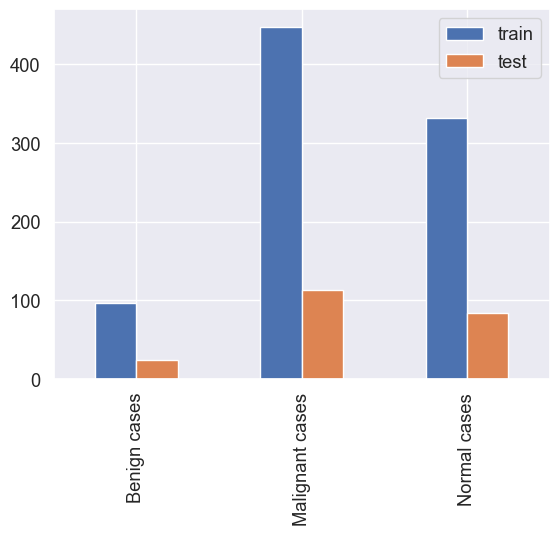

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
              'test': test_counts}, 
             index=class_names).plot.bar()

plt.show()

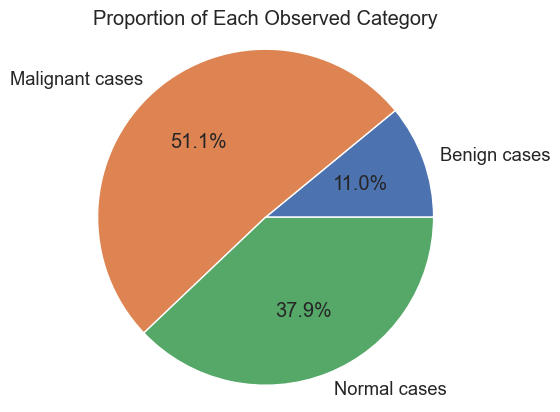

In [8]:
plt.pie(train_counts,
        explode=None, 
        labels=class_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of Each Observed Category')
plt.show()

# Data Preprocessing

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Initializing 

In [10]:
EPOCHS = 30
BATCH_SIZE = 64

# One-hot encoding

In [11]:
from tensorflow.keras.utils import to_categorical

num_classes = 3
train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)

# CNN Architecture

# Define Network

In [12]:
import tensorflow as tf 
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 128)               1

# Compile Network

In [15]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
plot_model(model, 'CNN Architecture.jpg', show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
#EARLY STOPPING
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')

#MODEL CHECKPOINTS
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"CNN.h5",verbose = 1,save_best_only = True,mode = 'auto')

cd_1 = [es,mc]


# Fit Network

In [18]:
history = model.fit(train_images, train_labels_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split = 0.2,callbacks=cd_1)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 4.6168 - accuracy: 0.4771
Epoch 1: val_accuracy improved from -inf to 0.54545, saving model to CNN.h5
11/11 [==============================] - 4s 146ms/step - loss: 4.6168 - accuracy: 0.4771 - val_loss: 0.9686 - val_accuracy: 0.5455
Epoch 2/30
10/11 [==========================>...] - ETA: 0s - loss: 0.8039 - accuracy: 0.6344
Epoch 2: val_accuracy improved from 0.54545 to 0.85227, saving model to CNN.h5
11/11 [==============================] - 1s 74ms/step - loss: 0.7845 - accuracy: 0.6486 - val_loss: 0.5437 - val_accuracy: 0.8523
Epoch 3/30
10/11 [==========================>...] - ETA: 0s - loss: 0.3453 - accuracy: 0.8922
Epoch 3: val_accuracy improved from 0.85227 to 0.92045, saving model to CNN.h5
11/11 [==============================] - 1s 78ms/step - loss: 0.3335 - accuracy: 0.8986 - val_loss: 0.2846 - val_accuracy: 0.9205
Epoch 4/30
10/11 [==========================>...] - ETA: 0s - loss: 0.1303 - accuracy: 0.9734

# VGG16 Architecture

# Define Network

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add Flatten layer and Dense layer to the base model
x = Flatten()(base_model.output)
predictions = Dense(num_classes, activation='softmax')(x)

In [21]:
model_2 = Model(inputs=base_model.input, outputs=predictions)

In [22]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Compile Network

In [23]:
model_2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# EarlyStopping
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')

#ModelCheckpoint
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"VGG16.h5",verbose = 1,save_best_only = True,mode = 'auto')

cd_2 = [es,mc]

# Fit Network

In [25]:
history_2 = model_2.fit(train_images, train_labels_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=cd_2)


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.3208 - accuracy: 0.5443
Epoch 1: val_accuracy improved from -inf to 0.71591, saving model to VGG16.h5
11/11 [==============================] - 13s 901ms/step - loss: 1.3208 - accuracy: 0.5443 - val_loss: 0.6888 - val_accuracy: 0.7159
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.7757
Epoch 2: val_accuracy improved from 0.71591 to 0.80682, saving model to VGG16.h5
11/11 [==============================] - 2s 170ms/step - loss: 0.5502 - accuracy: 0.7757 - val_loss: 0.4874 - val_accuracy: 0.8068
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8757
Epoch 3: val_accuracy improved from 0.80682 to 0.85227, saving model to VGG16.h5
11/11 [==============================] - 2s 169ms/step - loss: 0.3263 - accuracy: 0.8757 - val_loss: 0.3975 - val_accuracy: 0.8523
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 0.2062 - accurac

# Stacked Ensemble Model

https://machinelearningmastery.com/ensemble-machine-learning-with-python-7-day-mini-course/

https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, concatenate

In [27]:
# Load the trained models
model_cnn = tf.keras.models.load_model('CNN.h5')  
model_vgg16 = tf.keras.models.load_model('VGG16.h5')

In [28]:
# Create predictions for the training and test sets using both models
preds_cnn_train = model_cnn.predict(train_images)
preds_vgg16_train = model_vgg16.predict(train_images)

preds_cnn_test = model_cnn.predict(test_images)
preds_vgg16_test = model_vgg16.predict(test_images)

7/7 [==============================] - 3s 457ms/step


In [29]:
# Create a new model for stacking
stacked_model = Sequential([
    Dense(32, activation='relu', input_shape=(num_classes * 2,)),
    Dense(num_classes, activation='softmax')
])

In [30]:
# Concatenate the predictions of the base models
concatenated_train_preds = np.concatenate([preds_cnn_train, preds_vgg16_train], axis=1)
concatenated_test_preds = np.concatenate([preds_cnn_test, preds_vgg16_test], axis=1)

In [31]:
# EarlyStopping
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')

#ModelCheckpoint
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"Stacked_Model.h5",verbose = 1,save_best_only = True,mode = 'auto')

cd_3 = [es,mc]

In [32]:
# Train the meta-model on the concatenated predictions
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


stacked_model.fit(concatenated_train_preds, train_labels_one_hot, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=cd_3)

Epoch 1/30
 1/11 [=>............................] - ETA: 2s - loss: 1.0246 - accuracy: 0.4688
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to Stacked_Model.h5
11/11 [==============================] - 0s 20ms/step - loss: 0.9662 - accuracy: 0.5929 - val_loss: 0.9089 - val_accuracy: 0.8125
Epoch 2/30
 1/11 [=>............................] - ETA: 0s - loss: 0.9062 - accuracy: 0.8281
Epoch 2: val_accuracy improved from 0.81250 to 0.92614, saving model to Stacked_Model.h5
11/11 [==============================] - 0s 7ms/step - loss: 0.8467 - accuracy: 0.9443 - val_loss: 0.8000 - val_accuracy: 0.9261
Epoch 3/30
 1/11 [=>............................] - ETA: 0s - loss: 0.7740 - accuracy: 0.9531
Epoch 3: val_accuracy improved from 0.92614 to 0.94886, saving model to Stacked_Model.h5
11/11 [==============================] - 0s 6ms/step - loss: 0.7400 - accuracy: 0.9757 - val_loss: 0.7046 - val_accuracy: 0.9489
Epoch 4/30
 1/11 [=>............................] - ETA: 0s - loss

# Evaluation of Stacked Ensemble Model

In [33]:
import random
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [34]:
# Evaluate CNN Model
cnn_test_loss, cnn_test_acc = model.evaluate(test_images, to_categorical(test_labels, num_classes))
print("CNN Model Accuracy on Test Data: {:.2f}%".format(cnn_test_acc * 100))

# Evaluate VGG16 Model
vgg16_test_loss, vgg16_test_acc = model_2.evaluate(test_images, to_categorical(test_labels, num_classes))
print("VGG16 Model Accuracy on Test Data: {:.2f}%".format(vgg16_test_acc * 100))

# Evaluate Stacked Ensemble Model
# Note: Using the predictions from the CNN and VGG16 models on the test data

concatenated_test_preds = np.concatenate([preds_cnn_test, preds_vgg16_test], axis=1)
stacked_test_loss, stacked_test_acc = stacked_model.evaluate(concatenated_test_preds, to_categorical(test_labels, num_classes))
print("Stacked Ensemble Model Accuracy on Test Data: {:.2f}%".format(stacked_test_acc * 100))


7/7 [==============================] - 0s 14ms/step - loss: 0.0378 - accuracy: 0.9819
CNN Model Accuracy on Test Data: 98.19%
7/7 [==============================] - 1s 77ms/step - loss: 0.0519 - accuracy: 0.9955
VGG16 Model Accuracy on Test Data: 99.55%
7/7 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9955
Stacked Ensemble Model Accuracy on Test Data: 99.55%


In [35]:
stacked_test_loss, stacked_test_acc = stacked_model.evaluate(concatenated_test_preds, to_categorical(test_labels, num_classes))
print("Stacked Ensemble Model Accuracy on Test Data: {:.2f}%".format(stacked_test_acc * 100))

7/7 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9955
Stacked Ensemble Model Accuracy on Test Data: 99.55%


# Classification Report

In [36]:
# Make predictions
stacked_preds = stacked_model.predict(concatenated_test_preds)
stacked_pred_labels = np.argmax(stacked_preds, axis=1)

class_names = ['Benign cases', 'Malignant cases', 'Normal cases']

print('\033[1m' + 'Classification report : ' + '\033[0m\n', classification_report(test_labels, stacked_pred_labels))

7/7 [==============================] - 0s 1ms/step
Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.99      1.00      1.00       113
           2       1.00      0.99      0.99        84

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



# Confusion Matrix

Confusion Matrix : 


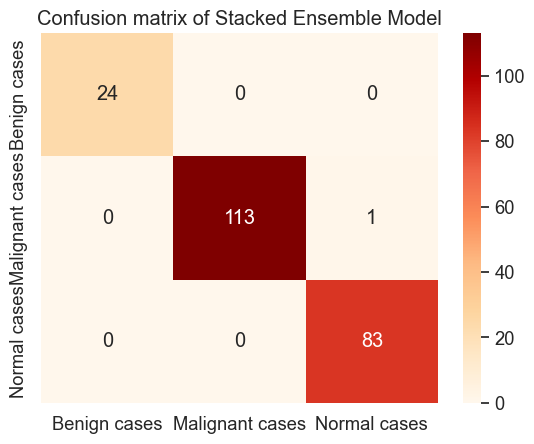

In [37]:
ax = plt.axes()
cm = confusion_matrix(stacked_pred_labels, test_labels)
print('\033[1m' + 'Confusion Matrix : ' + '\033[0m')
sn.heatmap(cm, cmap='OrRd', annot=True, fmt='d',
           xticklabels=class_names,
           yticklabels=class_names, ax=ax)
ax.set_title('Confusion matrix of Stacked Ensemble Model')
plt.show()

# Evaluation Metrics

In [38]:
print("Precision Score : ", precision_score(test_labels, stacked_pred_labels, average='weighted'))
print("Recall Score : ", recall_score(test_labels, stacked_pred_labels, average='weighted'))
print("F1 Score : ", f1_score(test_labels, stacked_pred_labels, average='weighted'))

Precision Score :  0.9955148051123283
Recall Score :  0.995475113122172
F1 Score :  0.9954715322678541


# Make Predictions

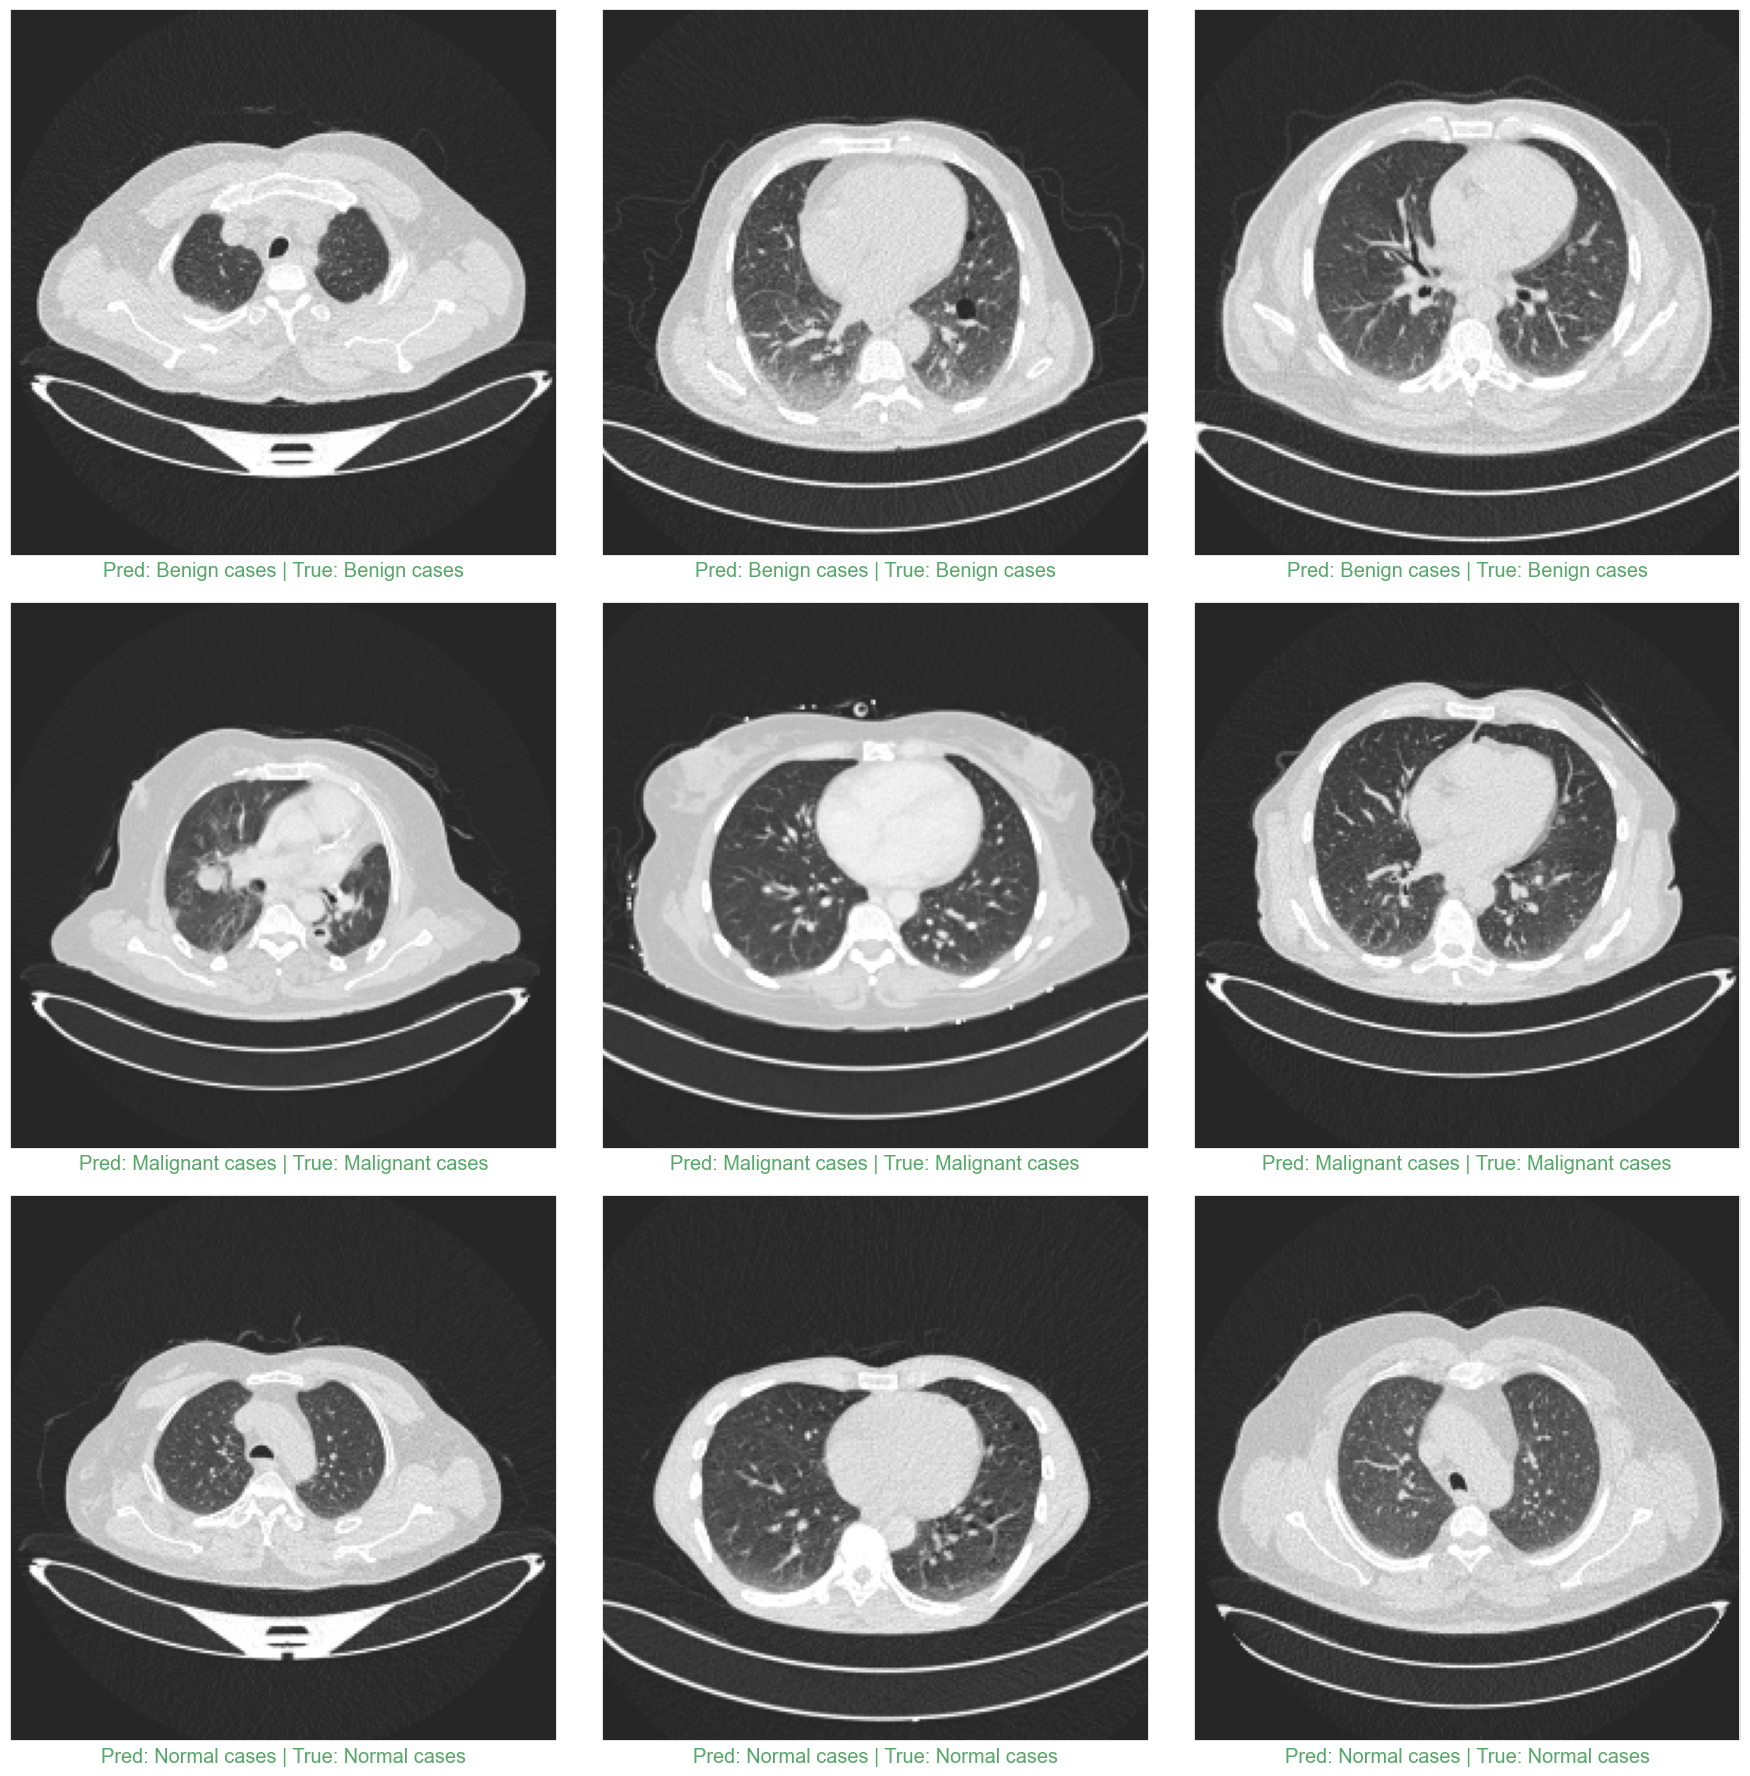

In [39]:
# Visualize Predictions
plt.figure(figsize=(18, 18)) 

num_classes = len(class_names)
images_per_class = 3  # Display at least 3 random images from each class

for class_label in range(num_classes):
    class_indices = np.where(test_labels == class_label)[0]
    random_indices = random.sample(list(class_indices), min(images_per_class, len(class_indices)))

    for i, index in enumerate(random_indices):
        plt.subplot(num_classes, images_per_class, class_label * images_per_class + i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        pred = stacked_pred_labels[index]
        actual = test_labels[index]
        col = 'g' if pred == actual else 'r'
        plt.xlabel('Pred: {} | True: {}'.format(class_names[pred], class_names[actual]), color=col)
        plt.imshow((test_images[index] * 255).astype(np.uint8))  # Reverse normalization for visualization

plt.tight_layout()
plt.show()
